# Forecast Exploration Notebook
This notebooks on predicting future performance of the world economy and financial markets based on financial time sereis and the world events time series (generated by the NLP workstream).

## DeepAR

In [6]:
# pip install "gluonts[torch]"

In [138]:
# Importing the necessary packages 
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
from gluonts.evaluation import Evaluator, backtest_metrics
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation.metrics import mape

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [55]:
# Load TTS from a CSV file into a DataFrame
file_name = "ww_gdp.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
tts_df = pd.read_csv(file_path)
# Format DataFrame
tts_col_map = {i:f"tts_{i}" for i in rts_df.columns if i.isnumeric()}
tts_df = tts_df.rename(columns={'Unnamed: 0': 'Week'})
tts_df['Week'] = tts_df['Week'].apply(lambda x: datetime.fromisoformat(x))
tts_df = tts_df.set_index('Week')
# Rename Columns
tts_col_map = {i:f"tts_{i}" for i in tts_df.columns}
tts_df = tts_df.rename(columns=tts_col_map)
tts_df.head()

,tts_Aruba,tts_Africa Eastern and Southern,tts_Afghanistan,tts_Africa Western and Central,tts_Angola,tts_Albania,tts_Andorra,tts_Arab World,tts_United Arab Emirates,tts_Argentina,...,tts_Virgin Islands (U.S.),tts_Vietnam,tts_Vanuatu,tts_World,tts_Samoa,tts_Kosovo,tts_Yemen,tts_South Africa,tts_Zambia,tts_Zimbabwe
Week,,,,,,,,,,,,,,,,,,,,,
1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Load RTS from a CSV file into a DataFrame
file_name = "ts_data_lda_model_topics_5_passes_10_on_title_lemmatized_cnbc_news_dataset_processed.csv"
file_path = f"../../data_engineering/timeseries_data/{file_name}"
rts_df = pd.read_csv(file_path)
# Format DataFrame
rts_col_map = {i:f"rts_{i}" for i in rts_df.columns if i.isnumeric()}
rts_df = rts_df.rename(
    columns=dict({'Unnamed: 0': 'Week'}, **rts_col_map)
)
rts_df['Week'] = rts_df['Week'].apply(lambda x: datetime.fromisoformat(x))
rts_df = rts_df.set_index('Week')
rts_df.index = rts_df.index.tz_localize(None)

rts_df.head()

,rts_0,rts_1,rts_2,rts_3,rts_4
Week,,,,,
2006-12-04,0.864812,0.033557,0.034168,0.033398,0.034065
2006-12-11,0.033342,0.866245,0.033369,0.033525,0.033519
2006-12-18,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-25,0.086091,0.084316,0.829804,0.084262,0.915527
2007-01-01,0.000000,0.000000,0.000000,0.000000,0.000000


In [127]:
# Join TTS and RTS into a single DataFrame
ts_df = tts_df.join(rts_df)
ts_df = ts_df.reset_index()
ts_df.head()

,Week,tts_Aruba,tts_Africa Eastern and Southern,tts_Afghanistan,tts_Africa Western and Central,tts_Angola,tts_Albania,tts_Andorra,tts_Arab World,tts_United Arab Emirates,...,tts_Kosovo,tts_Yemen,tts_South Africa,tts_Zambia,tts_Zimbabwe,rts_0,rts_1,rts_2,rts_3,rts_4
0,1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the following cell the pandas dataframe is converted into a [Dataset](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.pandas.html) which gives the data additional explicid structure.

In [128]:
# target_cols = list(tts_col_map.values())
# past_rts_col = list(rts_col_map.values())

In [129]:
dataset = PandasDataset(
    ts_df, 
    target='tts_United States', 
    timestamp='Week',
    freq='W',
    past_feat_dynamic_real=past_rts_col
)

In [130]:
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-32)
test_data = test_gen.generate_instances(prediction_length=32, windows=1)

In [131]:
# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=32, freq="W", trainer_kwargs={"max_epochs": 5}
).train(training_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 23.8 K | ?        | [1, 100, 32]
----------------------------------------------------------------
23.8 K    Trainable params
0         Non-trainable params
23.8 K    Total params
0.095     Total estimated model params size (MB)


Epoch 0: : 50it [00:07,  6.80it/s, v_num=14, train_loss=1.880]

Epoch 0, global step 50: 'train_loss' reached 1.88168 (best 1.88168), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_14/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:07,  6.83it/s, v_num=14, train_loss=0.916]

Epoch 1, global step 100: 'train_loss' reached 0.91611 (best 0.91611), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_14/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:07,  6.86it/s, v_num=14, train_loss=0.502]

Epoch 2, global step 150: 'train_loss' reached 0.50232 (best 0.50232), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_14/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:07,  6.95it/s, v_num=14, train_loss=0.200]

Epoch 3, global step 200: 'train_loss' reached 0.19980 (best 0.19980), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_14/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: : 50it [00:07,  6.75it/s, v_num=14, train_loss=0.248]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: : 50it [00:07,  6.72it/s, v_num=14, train_loss=0.248]


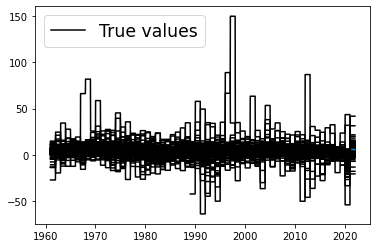

In [114]:
forecasts = list(model.predict(test_data.input))
# Plot predictions
plt.plot(ts_df, color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [134]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data,
        predictor=model,
        num_samples=100,
)

In [141]:
# forecasts = list(forecast_it)
forecasts = []
for forecast in forecast_it:
    forecasts.append(forecast)
tss = []
for ts in ts_it:
    tss.append(ts)

agg_metrics, item_metrics = evaluator(np.array(tss), np.array(forecasts))
# mape(
#     target=np.array(tss), 
#     forecast=np.array(forecasts)
# )


Running evaluation: 0it [00:00, ?it/s]


AssertionError: Some of the requested item metrics are missing.

In [ ]:
x